In [3]:
#
# Working through the example from
# https://github.com/salvadorgarciamunoz/kipet/blob/master/kipet/examples/Ex_7_concentration_input.py
#  
#  Trying the example with dataset Ex_1_C_data_withoutA.csv that has only conc data for B and C
#

In [ ]:

import kipet.library.ParameterEstimator
import imp
imp.reload(kipet.library.ParameterEstimator)

In [4]:
from __future__ import print_function
from kipet.library.TemplateBuilder import *
from kipet.library.PyomoSimulator import *
from kipet.library.ParameterEstimator import *
from kipet.library.VarianceEstimator import *
from kipet.library.data_tools import *
import matplotlib.pyplot as plt
import os
import sys
import inspect
import six
import pandas as pd

In [5]:
filename = '../data_sets/Ex_1_C_data_withoutA.csv'
C_frame = read_concentration_data_from_csv(filename)

In [6]:
C_frame

,B,C
0.0000,0.000000,0.000013
0.0333,0.000002,0.000021
0.0667,0.000013,0.000018
0.1000,0.000025,0.000014
0.1334,0.000035,0.000012
...,...,...
9.8353,0.000043,0.000859
9.8686,0.000042,0.000857
9.9020,0.000041,0.000859
9.9353,0.000043,0.000860


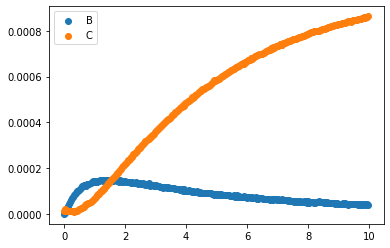

In [7]:
fig, ax = plt.subplots()
#ax.scatter(C_frame.index, C_frame['A'], label = 'A')
ax.scatter(C_frame.index, C_frame['B'], label = 'B')
ax.scatter(C_frame.index, C_frame['C'], label = 'C')
ax.legend()

In [8]:
builder = TemplateBuilder()    
components = {'A':1e-3,'B':0,'C':0}
builder.add_mixture_component(components)
builder.add_parameter('k1',bounds=(0.0,5.0))
builder.add_parameter('k2',bounds=(0.0,1.0))
builder.add_concentration_data(C_frame)

In [9]:
# define explicit system of ODEs
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.P['k1']*m.Z[t,'A']
    exprs['B'] = m.P['k1']*m.Z[t,'A']-m.P['k2']*m.Z[t,'B']
    exprs['C'] = m.P['k2']*m.Z[t,'B']
    return exprs
    
builder.set_odes_rule(rule_odes)
opt_model = builder.create_pyomo_model(0.0,10.0)

initial values: 0.0, A
initial values: 0.0, B
initial values: 0.0, C


In [10]:
#sigmas = {'A':1e-10,'B':1e-11,'C':1e-10}
sigmas = {'B':1e-11,'C':1e-10}

In [11]:
# and define our parameter estimation problem and discretization strategy
p_estimator = ParameterEstimator(opt_model)
p_estimator.apply_discretization('dae.collocation',nfe=60,ncp=3,scheme='LAGRANGE-RADAU')

    number of finite elements specified in apply. The larger number of finite
    elements will be used.


In [12]:
# Again we provide options for the solver, this time providing the scaling that we set above
options = dict()
#options['nlp_scaling_method'] = 'user-scaling'
options['linear_solver'] = 'ma27'

In [13]:
# finally we run the optimization
results_pyomo = p_estimator.run_opt('ipopt',
                                        variances=sigmas,
                                      tee=True,
                                   solver_opts = options)

Ipopt 3.13.2: linear_solver=ma27


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:    23403
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2400

Total number of variables............................:     5405
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:     5403
T

In [14]:
# And display the results
print("The estimated parameters are:")
for k,v in six.iteritems(results_pyomo.P):
    print(k, v)

The estimated parameters are:
k1 0.2268223273757557
k2 0.9815608867201315


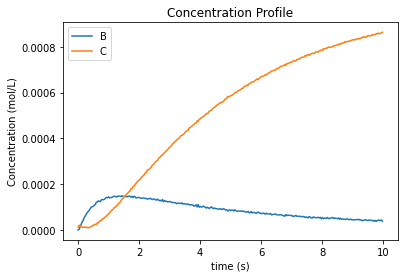

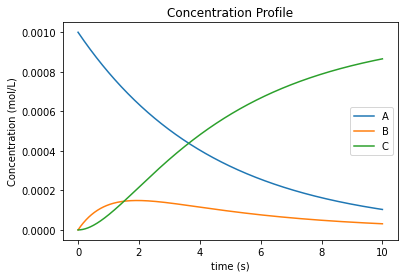

In [15]:
results_pyomo.C.plot.line(legend=True)
plt.xlabel("time (s)")
plt.ylabel("Concentration (mol/L)")
plt.title("Concentration Profile")

results_pyomo.Z.plot.line(legend=True)
plt.xlabel("time (s)")
plt.ylabel("Concentration (mol/L)")
plt.title("Concentration Profile")


plt.show()